### This jupyter notebook is to recognize faces on picture

##### Importing libraries

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import cv2
import time
import os
import shutil
import matplotlib.pyplot as plt

##### Initializing MTCNN and InceptionResnetV1

In [2]:
# initializing MTCNN and InceptionResnetV1 
mtcnn0 = MTCNN(image_size=240, margin=0, keep_all=False, min_face_size=40) # keep_all=False
mtcnn = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40) # keep_all=True
resnet = InceptionResnetV1(pretrained='vggface2').eval() 

##### Load Data Exited Or Create New DataSet

In [4]:
path_flag = os.path.exists('data.pt')
if path_flag:
    load_data = torch.load('data.pt') 
    embedding_list = load_data[0] 
    name_list = load_data[1]
else:
    embedding_list = []
    name_list = []

##### Update New Face To Dataset

In [5]:
# Update Data From Folder
fartherFolder = 'photos_aligned/Aligned Images'
fartherCroped = 'photos_aligned/Cropped_Images'
database_folder = "photos_database"
people_count =  len(os.listdir(fartherFolder))
def collate_fn(x):
    return x[0]
def moveFolderInfolder(fartherFolder,des):
    folders =  os.listdir(fartherFolder)
    if(len(folders)>0):
        for folder in folders:
            shutil.move(fartherFolder+'/'+folder, des)
    return folders
if(people_count > 0):
    dataset = datasets.ImageFolder(fartherFolder) # photos folder path
    idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names
    loader = DataLoader(dataset, collate_fn=collate_fn)
    for img, idx in loader:
        face, prob = mtcnn0(img, return_prob=True) 
        if face is not None and prob>0.92:
            emb = resnet(face.unsqueeze(0)) 
            embedding_list.append(emb.detach()) 
            name_list.append(idx_to_class[idx])
    #move folder photos to database folder        
    moveFolderInfolder(fartherFolder,database_folder)
    # save data
    data = [embedding_list, name_list] 
    torch.save(data, 'data.pt') # saving data.pt file
print(f"{people_count} new people added to database")

11 new people added to database


##### Load Dataset From File Saved

In [6]:
load_data = torch.load('data.pt') 
embedding_list = load_data[0] 
name_list = load_data[1]

##### Compare Face And Predict With Input Image

In [7]:
# power = 1
def predict_face(img):
    data_peoples = []
    min_dist = 0
    img_cropped_list, prob_list = mtcnn(img, return_prob=True)
    if img_cropped_list is not None:
        boxes, _ = mtcnn.detect(img)
        name_peoples = []
        box_peoples = []
        min_dist_list = []
        count_Unknown = 0
        if boxes is not None:
            # for box in boxes:
            for i, prob in enumerate(prob_list):
                if prob > 0.90:
                    emb = resnet(img_cropped_list[i].unsqueeze(0)).detach()
                    dist_list = []  # list of matched distances, minimum distance is used to identify the person
                    for idx, emb_db in enumerate(embedding_list):
                        dist = torch.dist(emb, emb_db).item()
                        dist_list.append(dist)
                        min_dist = min(dist_list)  # get minumum dist value
                        min_dist_idx = dist_list.index(
                            min_dist)  # get minumum dist index
                        box = boxes[i]  # get box of face
                        if(min_dist < 0.90):
                             # get name corrosponding to minimum dist
                            name = name_list[min_dist_idx]          
                        else:
                            name = "Unknown"  # get name corrosponding to minimum dist           
                            count_Unknown += 1
                            if(count_Unknown > 100):
                                bbox = list(map(int,box.tolist()))
                                img = cv2.rectangle(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,0,255), 2)
                                img = cv2.putText(img, name + '_{:.2f}'.format(dist), (bbox[0],bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1, cv2.LINE_8)
                                break 
                # print("Name:", name)
                # print("Min dist:", min_dist)
                # print("Min dist idx:", min_dist_idx)
                # print("idx", idx)
                        box_peoples.append(box)
                        name_peoples.append(name)
                        min_dist_list.append(min_dist)
                #score = (torch.Tensor.cpu(min_dist.detach().numpy()*power))
                bbox = list(map(int,box.tolist()))
                img = cv2.rectangle(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,0,255), 2)
                img = cv2.putText(img, name + '_{:.2f}'.format(min_dist), (bbox[0],bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1, cv2.LINE_8)    
    data_peoples = [name_peoples, box_peoples,min_dist_list]
    return data_peoples

##### Input a face from image to test

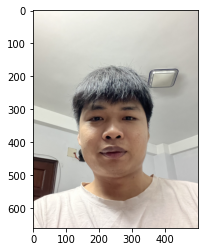

In [8]:
#Load images from folder
# img_path = r"D:\DATN_MachineLearning\live_face_recognition\test\Unknown.jpg"
img_path = r"D:\DATN_MachineLearning\live_face_recognition\test\chuongtest.jpg"
# img_path = r"D:\DATN_MachineLearning\live_face_recognition\test\trieutest.jpg"
#read image RGB
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500, 660)) 
# cv2.imshow('RGB Image',img_rgb )
plt.imshow(img)

##### Predict Face And Show OutPut

Len Data Name Predicts: 217
Count Unknown: 0
Count Known: 217


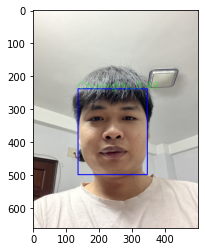

In [9]:
datapredicts = predict_face(img)
names = datapredicts[0]
Unknowns = len([i for i in names if i == "Unknown"])
print("Len Data Name Predicts:", len(datapredicts[0]))
print("Count Unknown:", Unknowns)
print("Count Known:", len(names)-Unknowns)
plt.imshow(img)

##### Save Image To Location

In [10]:
#save image open cv
filepath = "result"+"/"+os.path.basename(img_path)
full_filepath = os.path.abspath(filepath)
saved =  cv2.imwrite(filepath, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
if saved:
    print(f'Image saved to {full_filepath}')
import subprocess
subprocess.call(f"explorer {full_filepath}", shell=True)

Image saved to d:\DATN_MachineLearning\live_face_recognition\result\chuongtest.jpg


1